In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import pystan
import re
from scipy.interpolate import interp1d
from sklearn.mixture import GaussianMixture
import seaborn as sns
from tqdm import tqdm_notebook
from true_params import true_params

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

In [3]:
with h5py.File('observations.h5', 'r') as f:
    m1s = array(f['posteriors']['m1det'])
    m2s = array(f['posteriors']['m2det'])
    dls = array(f['posteriors']['dl'])

We want to know how many components to use in the GMM approximation to the likelihood; it seems that using $\sim 6$ is sufficient to get reasonable approximations to all the systems.  We use half the posterior samples to test and the other half to train:

In [4]:
scores = {}

In [14]:
k = 7
gmm = GaussianMixture(k)

scores[k] = []

for i in tqdm_notebook(range(m1s.shape[0])):
    pts = column_stack((m1s[i,:], m2s[i,:], dls[i,:]))
    n = pts.shape[0]
    n2 = n//2
    
    gmm.fit(pts[:n2,:])
    
    scores[k].append(gmm.score(pts[n2:,:]))

Executing the above cell for several different numbers of componets, we see that with six components to the mixture, we have basically reached diminishing returns in average score over the test set; with seven we actually reduce the average score a bit, presumably due to over-fitting.  With six components there are not really any massive outliers.

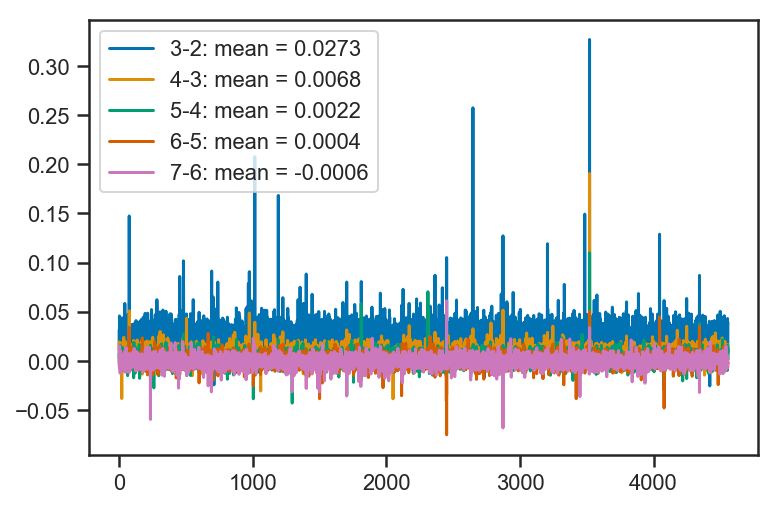

In [18]:
for k in sort(array(list(scores.keys())))[:-1]:
    k1 = k+1
    s1 = array(scores[k1])
    s = array(scores[k])
    
    m = mean(s1)-mean(s)
    
    plot(s1-s, label='{:d}-{:d}: mean = {:.4f}'.format(k1,k,m))
legend(loc='best')

Once we have the ``gmm`` object, we can get the weights, means, and covariances via:

In [19]:
gmm.weights_, gmm.means_, gmm.covariances_

(array([0.21242665, 0.08502627, 0.18405627, 0.12629209, 0.14667345,
        0.19937247, 0.0461528 ]),
 array([[37.00868078, 30.5957516 ,  1.24801029],
        [41.88610679, 27.28659963,  1.2190881 ],
        [34.26894532, 33.03300695,  1.2754271 ],
        [40.22815395, 28.41194874,  1.23926542],
        [38.57154097, 29.47584576,  1.24578498],
        [35.45544573, 31.95499416,  1.24137218],
        [44.17418592, 26.07482741,  1.17616111]]),
 array([[[ 0.39287245, -0.20076096,  0.00404714],
         [-0.20076096,  0.2922292 ,  0.00203225],
         [ 0.00404714,  0.00203225,  0.02575314]],
 
        [[ 0.73246094, -0.30076513, -0.00789099],
         [-0.30076513,  0.25184529,  0.01299493],
         [-0.00789099,  0.01299493,  0.0304497 ]],
 
        [[ 0.22056883, -0.08320619,  0.00709767],
         [-0.08320619,  0.20166007, -0.00457801],
         [ 0.00709767, -0.00457801,  0.02743194]],
 
        [[ 0.52485133, -0.26348891,  0.00168483],
         [-0.26348891,  0.2902775 , -0.00576